In [66]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import fibernet

path = "C:/Users/saucourt/Coding/fibernet_analysis/training_analysis/trained_models"
model_name = "model_ds=10k_p=1_na=0.2_ep=40.pth"
model = torch.load(os.path.join(path, model_name))

amp = fibernet.dataset._utils.make_bellshaped_plane_2d(np.zeros(shape=(6,6)))
amp = amp.flatten()
amp = np.delete(amp, [0, 5, 30, 35])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
def kN_tests(x, target, model, dither: float = 0.2, loops: int = 3, norm: bool = True):
    x0 = x.copy()
    J_max = np.sum(infer(x0, model))
    acts = x.shape[0]
    max_iter = loops * acts
    J = np.zeros(shape=(max_iter,))

    i = 0
    for _ in range(loops):
        for act in range(acts):
            x_plus, x_minus = x.copy(), x.copy()
            x_plus[act] = np.array(x[act] * np.exp(+1j * dither))
            x_minus[act] = np.array(x[act] * np.exp(-1j * dither))

            if norm:
                J0 = 1-np.linalg.norm(my_norm(infer(x, model)) - my_norm(target))
                J_plus = 1-np.linalg.norm(my_norm(infer(x_plus, model)) - my_norm(target))
                J_minus = 1-np.linalg.norm(my_norm(infer(x_minus, model)) - my_norm(target))
            else:
                J0 = np.sum(infer(x, model) * target) / J_max
                J_plus = np.sum(infer(x_plus, model) * target) / J_max
                J_minus = np.sum(infer(x_minus, model) * target) / J_max
            
            Re = (2*J0 - J_plus - J_minus) / (4 * (1 - np.cos(dither)))
            Im = (J_plus - J_minus) / (4 * np.sin(dither))
            corr = np.angle(Re + 1j * Im)
            x[act] = x[act] * np.exp(1j * corr)

            if norm:
                J[i] = 1-np.linalg.norm( my_norm(infer(x, model)) - my_norm(target) )
            else:
                J[i] = np.sum(infer(x, model) * target) / J_max
            i += 1
    return J, x


def my_norm(x):
    return x/ np.linalg.norm(x)


def infer(x, model, intensity: bool = True):
    img = model(torch.tensor(x).type(torch.complex64).to('cuda')).cpu().detach().numpy()
    return np.square(np.squeeze(img)) if intensity else np.squeeze(img)


def circ_target(model, radius: int = 5, center: tuple[int, int] = (0,0), invert: bool = False):
    target = np.zeros(shape=model.intens_shape)
    x = np.arange(0, target.shape[0]) - target.shape[0]/2
    X, Y = np.meshgrid(x, x)
    R = np.sqrt(np.square(X - center[0]) + np.square(Y - center[1]))
    target[R <= radius] = 1

    if invert:
        target = np.logical_not(target)
    return target


def ring_target(model, radius: tuple[int, int] = (5, 10), center: tuple[int, int] = (0,0)):
    target = np.zeros(shape=model.intens_shape)
    x = np.arange(0, target.shape[0]) - target.shape[0]/2
    X, Y = np.meshgrid(x, x)
    R = np.sqrt(np.square(X - center[0]) + np.square(Y - center[1]))
    target[np.logical_and(R >= radius[0], R <= radius[1])] = 1
    return target


def show_results(x0, x_opt, energy, model, target):
    fig, axs = plt.subplots(2, 2, figsize=(8,5))
    pl0 = axs[0,0].imshow(infer(x0, model))
    pl1 = axs[0,1].imshow(infer(x_opt, model))
    pl2 = axs[1,0].imshow(target)
    axs[1,1].plot(energy * 100)
    axs[0,0].axis('off')
    axs[0,1].axis('off')
    axs[1,0].axis('off')
    axs[0,0].set_title('Initial intensity')
    axs[0,1].set_title('Optimized intensity')
    axs[1,0].set_title('Target')
    axs[1,1].set_title('Energy in target')
    axs[1,1].set_xlabel('Actuation #')
    axs[1,1].set_ylabel('Energy [%]')

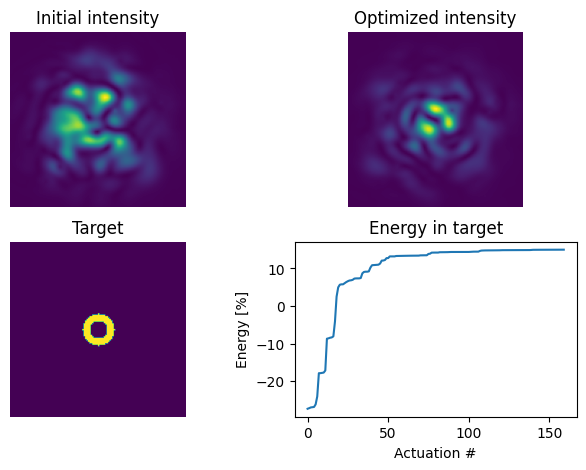

In [265]:
phi = 2 * np.pi * np.random.rand(model.phases_dim)
x0 = amp * np.exp(1j * phi)

# target = circ_target(model, radius=5, center=(-10,0)) + circ_target(model, radius=5, center=(10,0)) + circ_target(model, radius=5, center=(10,10)) + circ_target(model, radius=5, center=(-10,-10))
# target = circ_target(model, radius=5, center=(0,-20)) + circ_target(model, radius=5, center=(0,20))
# target = circ_target(model, radius=7, center=(0,-10))
target = ring_target(model, radius=(6,11), center=(0,0))
energy, x_opt = kN_tests(x0.copy(), target=target, model=model, dither=0.1, loops=5, norm=True)
show_results(x0, x_opt, energy, model, target)